In [1]:
import configparser
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import subprocess
import sys

import matplotlib

import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker


sys.path.append("/dors/capra_lab/users/fongsl/tools/py_")

import config_readwrite as crw
import split_filename
import fet

# get plotting scripts

In [2]:
import plot_params as pp

pp.fonts()  # load font parameters
summary_labels = pp.summary_labels()  # get categorical labels for activity codes

# load config 

## analysis config 

In [3]:
name = "/data/hodges_lab/ATAC-STARR_B-cells/bin_human-evolution/config"
config, configfile_name = crw.read_config(name)

In [4]:
FILES = config["PHASTCONS"]["path"]
RE = config["PHASTCONS"]["RESULTS"]
REGIONS = config["CIS_TRANS"]["regions_annotations"]

regions = pd.read_csv(REGIONS, sep = '\t')
regions.head()

,#chr,start,end,region_id,conserved_active.regions,cis,trans,trans_only,cis_only,cis+trans,...,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans,peak_id
0,chr1,959034,959154,chr1:959034-959154,0.0,1.0,1.0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,chr1:958624-959633
1,chr1,1002089,1002179,chr1:1002089-1002179,0.0,1.0,1.0,0,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,chr1:1001489-1002748
2,chr1,1064140,1064260,chr1:1064140-1064260,0.0,1.0,0.0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chr1:1063549-1064889
3,chr1,1214948,1215208,chr1:1214948-1215208,0.0,1.0,1.0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,chr1:1214708-1216904
4,chr1,1215328,1215508,chr1:1215328-1215508,0.0,1.0,0.0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,chr1:1214708-1216904


# Make joined DF

## open PHASTCONS, open ACTIVITY DF, merge on bins

In [5]:
fs = glob.glob(os.path.join(FILES, "*.bed"))

results = {}
shuf_keys = {}

for f in fs:
    
    # get names
    path, region_file, region = split_filename.split_filename(f)

    df = pd.read_csv(f, sep = '\t', header = None)  # read phastCons file

    # rname columns
    cols = ["#chr", "start", "end", "bin_id", "phastcons"]
    df.columns = cols  # rename the columns
    
    # create phastcons binary col
    df['phastbin']=0
    df.loc[df["phastcons"]>1, "phastbin"]=1 # make a binary col 

    # mark shuffle or not shuffled
    df["shuffle"] = region  # rename column
    
    # if this is the test dataframe, merge w/ region info
    if "all_uniq_diffAct_regions2_phastcons-30way" in f:
        df = pd.merge(df, regions, how = "left")
        results[region] = df
    else:
        
        shuf_keys[region] = df


## clean up misnamed peaks (these make duplicate records in datatable)

In [6]:
shufs = pd.concat(shuf_keys.values())

shufs.shape

(193644, 7)

In [7]:
df = results["all_uniq_diffAct_regions2_phastcons-30way"]

df.head()

,#chr,start,end,bin_id,phastcons,phastbin,shuffle,region_id,conserved_active.regions,cis,...,HH-active_MM-inactive_HM-inactive_trans,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_cis+trans,MM-active_HH-inactive_HM-inactive_cis,MM-active_HH-inactive_MH-inactive_trans,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_cis+trans,peak_id
0,chr1,959034,959154,chr1:959034-959154,1,0,all_uniq_diffAct_regions2_phastcons-30way,chr1:959034-959154,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,chr1:958624-959633
1,chr1,1002089,1002179,chr1:1002089-1002179,0,0,all_uniq_diffAct_regions2_phastcons-30way,chr1:1002089-1002179,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,chr1:1001489-1002748
2,chr1,1064140,1064260,chr1:1064140-1064260,0,0,all_uniq_diffAct_regions2_phastcons-30way,chr1:1064140-1064260,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,chr1:1063549-1064889
3,chr1,1214948,1215208,chr1:1214948-1215208,0,0,all_uniq_diffAct_regions2_phastcons-30way,chr1:1214948-1215208,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,chr1:1214708-1216904
4,chr1,1215328,1215508,chr1:1215328-1215508,0,0,all_uniq_diffAct_regions2_phastcons-30way,chr1:1215328-1215508,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,chr1:1214708-1216904


In [8]:
"""
ANNOTATE!
(0) keep only specific columns

"""

keep = [
    'phastbin',
        'region_id',
        'phastcons',
        'conserved_active.regions',
         #'cis',
         #'trans',
         #'trans_only',
         #'cis_only',
         #'cis+trans',
         #'cis+trans_HH',
         #'cis+trans_MM',
         #'HH_active',
         #'MM_active',
         #'HH-active_MM-inactive.regions',
         #'MM-active_HH-inactive.regions',
         #'HH-active_MM-inactive_MH-inactive_cis',
         #'HH-active_MM-inactive_HM-inactive_trans',
         'HH-active_MM-inactive_cis-only',
         'HH-active_MM-inactive_trans-only',
         'HH-active_MM-inactive_cis+trans',
         #'MM-active_HH-inactive_HM-inactive_cis',
         #'MM-active_HH-inactive_MH-inactive_trans',
         'MM-active_HH-inactive_cis-only',
         'MM-active_HH-inactive_trans-only',
         'MM-active_HH-inactive_cis+trans',
     'cis_only', "trans_only", "cis+trans"

        ]
df = df[keep]


# Phastcons enrichment in HH active bins
- test 1111, cis, trans, cis+trans

In [9]:
def get_fp_counts(test, df):
    
    test_region_ids = set(df.loc[df[test]==1, "region_id"])
    nottest_region_ids = set(df.loc[df[test]!=1, "region_id"])
    
    return test_region_ids, nottest_region_ids

# PhastCons v. flanking shuffles 

## FET for PhastCons enrichment

       phastcons overlap.   no phastcons  overlap
    AS      A.         B
    shuf    C.         D

In [10]:
shufs["phastbin"].shape[0]

193644

In [11]:
rdict = {}
phasttest = df.loc[df.phastcons == 1]
phastshuf = shufs.loc[shufs.phastcons == 1]

test_cols =[
            'conserved_active.regions',    
            'cis_only', "trans_only", "cis+trans",
            'HH-active_MM-inactive_cis-only',
            'HH-active_MM-inactive_trans-only',
            'HH-active_MM-inactive_cis+trans',
            'MM-active_HH-inactive_cis-only',
            'MM-active_HH-inactive_trans-only',
            'MM-active_HH-inactive_cis+trans',
]

d,c = (shufs["phastbin"].shape[0] - shufs["phastbin"].sum()), shufs["phastbin"].sum()
for t in test_cols:
   
    b,a = df.groupby("phastbin")[t].sum().reset_index().iloc[:,1]
    
    results = fet.get_2x2(a,b,c,d,t)
    results["col"]= t
    rdict[t] = results


# FDR correction
fdr = fet.fdr_correction(rdict)
fdr["frac"] = fdr["a"]/ (fdr["a"]+ fdr["b"])
fdr

[[772.0, 1625.0], [23655, 169989]]
conserved_active.regions [[772.0, 1625.0], [23655, 169989]] 3.4139865177308426 1.2502327513229995e-142
[[376, 1682], [23655, 169989]]
cis_only [[376, 1682], [23655, 169989]] 1.6064222846703164 4.602058935281683e-15
[[460, 1587], [23655, 169989]]
trans_only [[460, 1587], [23655, 169989]] 2.082949647560494 1.4014831763275503e-37
[[1224, 8952], [23655, 169989]]
cis+trans [[1224, 8952], [23655, 169989]] 0.982560296215198 0.586653442022988
[[229.0, 845.0], [23655, 169989]]
HH-active_MM-inactive_cis-only [[229.0, 845.0], [23655, 169989]] 1.9474962947398438 7.103318864711071e-17
[[186.0, 605.0], [23655, 169989]]
HH-active_MM-inactive_trans-only [[186.0, 605.0], [23655, 169989]] 2.209303783205899 1.7673207636295267e-18
[[751.0, 4684.0], [23655, 169989]]
HH-active_MM-inactive_cis+trans [[751.0, 4684.0], [23655, 169989]] 1.1521815519527885 0.00046088873555956314
[[147.0, 837.0], [23655, 169989]]
MM-active_HH-inactive_cis-only [[147.0, 837.0], [23655, 169989]] 1

,a,b,c,d,OR,P,ci_lower,ci_lower_diff,ci_upper,ci_upper_diff,OR_log2,ci_lower_log2,ci_upper_log2,comparison,col,reject_null,FDR_P,asterisks,-log10p,frac
0,772.0,1625.0,23655,169989,3.413987,1.250233e-142,3.130317,0.125149,3.723362,0.125149,1.771457,1.646309,1.896606,conserved_active.regions,conserved_active.regions,True,1.250233e-141,*,140.903009,0.322069
0,376.0,1682.0,23655,169989,1.606422,4.602059e-15,1.435308,0.162491,1.797936,0.162491,0.683851,0.521361,0.846342,cis_only,cis_only,True,7.670098e-15,*,14.115199,0.182702
0,460.0,1587.0,23655,169989,2.082950,1.401483e-37,1.875943,0.151012,2.312799,0.151012,1.058628,0.907616,1.209640,trans_only,trans_only,True,7.007416e-37,*,36.154442,0.224719
0,1224.0,8952.0,23655,169989,0.982560,5.866534e-01,0.924177,0.088377,1.044632,0.088377,-0.025382,-0.113759,0.062995,cis+trans,cis+trans,False,5.866534e-01,None,0.231618,0.120283
0,229.0,845.0,23655,169989,1.947496,7.103319e-17,1.681851,0.211570,2.255099,0.211570,0.961621,0.750050,1.173191,HH-active_MM-inactive_cis-only,HH-active_MM-inactive_cis-only,True,1.420664e-16,*,15.847509,0.213222
0,186.0,605.0,23655,169989,2.209304,1.767321e-18,1.873468,0.237881,2.605342,0.237881,1.143592,0.905711,1.381473,HH-active_MM-inactive_trans-only,HH-active_MM-inactive_trans-only,True,4.418302e-18,*,17.354745,0.235145
0,751.0,4684.0,23655,169989,1.152182,4.608887e-04,1.065480,0.112865,1.245939,0.112865,0.204368,0.091503,0.317233,HH-active_MM-inactive_cis+trans,HH-active_MM-inactive_cis+trans,True,5.761109e-04,*,3.239494,0.138178
0,147.0,837.0,23655,169989,1.262088,1.111840e-02,1.058618,0.253631,1.504667,0.253631,0.335813,0.082182,0.589444,MM-active_HH-inactive_cis-only,MM-active_HH-inactive_cis-only,True,1.235378e-02,*,1.908200,0.149390
0,274.0,982.0,23655,169989,2.005104,2.747333e-21,1.752595,0.194185,2.293995,0.194185,1.003677,0.809492,1.197862,MM-active_HH-inactive_trans-only,MM-active_HH-inactive_trans-only,True,9.157777e-21,*,20.038210,0.218153
0,473.0,4268.0,23655,169989,0.796406,2.046454e-06,0.723542,0.138428,0.876608,0.138428,-0.328424,-0.466851,-0.189996,MM-active_HH-inactive_cis+trans,MM-active_HH-inactive_cis+trans,True,2.923505e-06,*,5.534096,0.099768


In [12]:
def annotate_bar(graph, ax, annot, height):

    if ax == "x":
    
        for p, a in zip(graph.patches, annot):

            graph.annotate(a, 
                            (p.get_x() + p.get_width() / 2.0, height),
                            #p.get_height()-1), 
                            ha = 'center', 
                            va = 'center', 
                            xytext = (0, 5),
                            textcoords = 'offset points')

def plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # get difference between y and upper/lower CI for plotting. 
    l = np.array(data[y]-data[ci_lower])
    u = np.array(data[ci_upper]- data[y])
             
    yerr = [l, u]

    sns.barplot(
            x=x, y=y, data=data,
            #order = order,
            #hue = hue,
            linewidth=2.5, 
            #facecolor=(1, 1, 1, 0),
            edgecolor=".2",
            yerr=yerr
            )
   
    plt.axhline(0, color = "grey", linewidth = 2.5)  # plot a line at zero


    #ax.set_xticklabels(["Complex\nEnhancer", "Simple\nEnhancer", "Complex\nEnhancer\nCore v. Derived"])

    ax.set_xlabel("")

    #ax.get_yaxis().ticker.LogLocator(base=2)

    # set the y ticks
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(2**x))
    ax.yaxis.set_major_formatter(ticks)
    ax.yaxis.set_major_locator(MultipleLocator(ytick_multiple))
    ax.set(
        xlabel = "",
        ylabel="Odds ratio\n(scaled log2)",  # y label
        title = title,
        ylim=ylim)
    return fig, ax



In [13]:
plot_sets = {
            "all":
                ['cis_only', 'trans_only', "cis+trans","conserved_active.regions", ],
    "fig":
                [ 'cis_only','trans_only', "cis+trans"],
            "HH-active_MM-inactive":
                ['HH-active_MM-inactive_cis-only','HH-active_MM-inactive_trans-only','HH-active_MM-inactive_cis+trans'],
            "MM-active_HH-inactive":
                ['MM-active_HH-inactive_cis-only','MM-active_HH-inactive_trans-only','MM-active_HH-inactive_cis+trans']
            }

In [14]:
set(fdr["comparison"])

{'HH-active_MM-inactive_cis+trans',
 'HH-active_MM-inactive_cis-only',
 'HH-active_MM-inactive_trans-only',
 'MM-active_HH-inactive_cis+trans',
 'MM-active_HH-inactive_cis-only',
 'MM-active_HH-inactive_trans-only',
 'cis+trans',
 'cis_only',
 'conserved_active.regions',
 'trans_only'}

In [15]:
data

NameError: name 'data' is not defined

['cis_only', 'trans_only', 'cis+trans', 'conserved_active.regions']
['cis_only', 'trans_only', 'cis+trans']
['HH-active_MM-inactive_cis-only', 'HH-active_MM-inactive_trans-only', 'HH-active_MM-inactive_cis+trans']
['MM-active_HH-inactive_cis-only', 'MM-active_HH-inactive_trans-only', 'MM-active_HH-inactive_cis+trans']


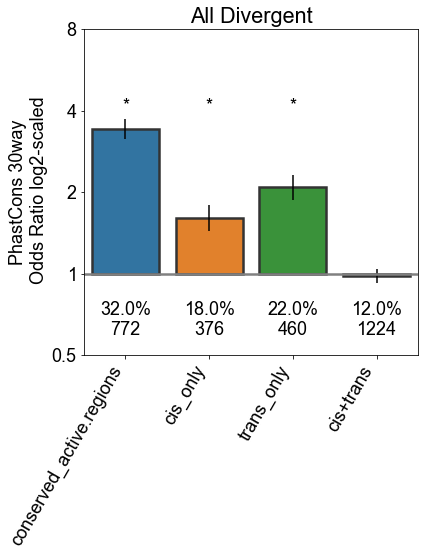

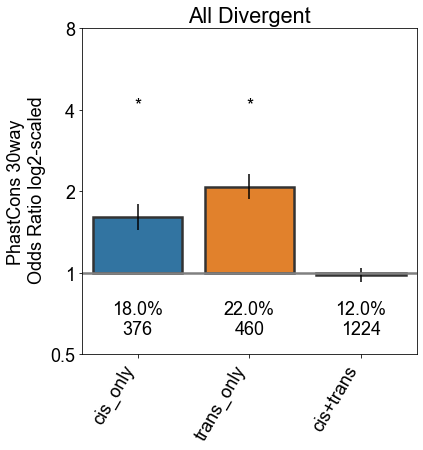

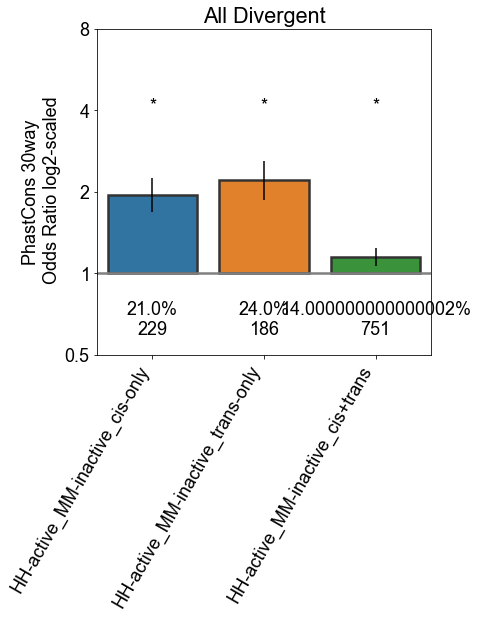

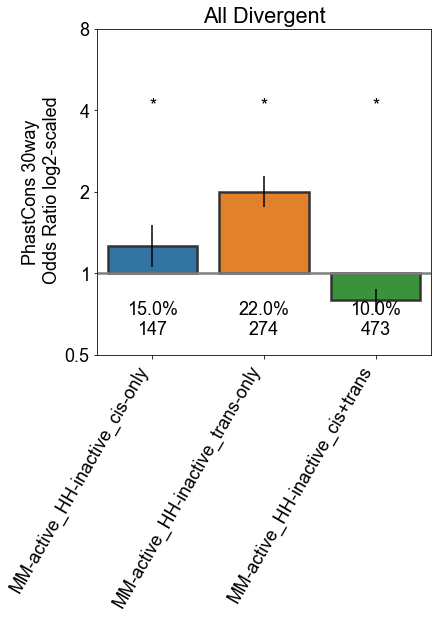

In [17]:
for key, value in plot_sets.items():
    print(value)
 
    x,y ="comparison", "OR_log2"
    order = test_cols #["cons_act", "trans_only", "cis_only",  "hu_cis_and_trans"]
    data = fdr.loc[fdr["comparison"].isin(value)]
    ci_upper, ci_lower= "ci_upper_log2","ci_lower_log2"

    ytick_multiple = 1
    ylim = (-1,3)
    title = f"All Divergent"

    hue = None

    # plot
    fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title)

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")
    ax.set( ylabel = "PhastCons 30way\n Odds Ratio log2-scaled"
        #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
    )
    plotc = data["a"].astype(int)
    annotate_bar(ax, "x", plotc, -0.75)
    plota = data["asterisks"]
    annotate_bar(ax, "x", plota, 2)
    plota = data["frac"].round(2).apply(lambda x: str(x*100)+"%")
    annotate_bar(ax, "x", plota, -0.5)

    outf = os.path.join(RE, f"HH_phastCons_enrichment_{key}_v_10x_shuffle.pdf")

    plt.savefig(outf, bbox_inches = "tight")

In [ ]:
fdr["frac"] = fdr["a"]/ (fdr["a"] + fdr["b"])

In [ ]:
x, y = "comparison", "frac"
order = test_cols#"cons_act", "trans_only", "cis_only",  "hu_cis_and_trans"]
data = fdr.set_index("comparison").loc[order].reset_index()
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x=x,y=y,data=data )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")

ax.set(
    title = "phastCons",
    ylabel = "Fraction overlap",
    #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
)

plotc = data["a"].astype(int)
annotate_bar(ax, "x", plotc, 0.01)

outf = os.path.join(RE, "phastCons_frac.pdf")

plt.savefig(outf, bbox_inches = "tight")

In [ ]:
rdict2 = {}
phasttest = df.loc[df.phastcons == 1]
phastshuf = df.loc[df.phastcons != 1]

test_cols =[
    'conserved_active.regions',    
    'cis_only', "trans_only", "cis+trans"
]


for t in test_cols:
   
    b,a = df.groupby("phastbin")[t].sum().reset_index().iloc[:,1] # for col, get n regions overlapping phastcons
    test_col_regions = set(phasttest.loc[phasttest[t]==1, "region_id"]) # get list of region ids to exclude from non-col set.

    not_col = df.loc[~df["region_id"].isin(test_col_regions)]  # get other part of dataset wo test regions
    c,d = not_col["phastbin"].sum(), (not_col.shape[0] - not_col["phastbin"].sum())  # count n regions overlapping phastcons, but not column

    
    results = fet.get_2x2(a,b,c,d,t)
    rdict2[t] = results


# FDR correction
fdr2 = fet.fdr_correction(rdict2)


x,y ="comparison", "OR_log2"
order = test_cols #["cons_act", "trans_only", "cis_only",  "hu_cis_and_trans"]
data = fdr2.set_index("comparison").loc[order].reset_index()
ci_upper, ci_lower= "ci_upper_log2","ci_lower_log2"

ytick_multiple = 1
ylim = (-1.5,2)
title = "phastCons enrichment\n HH active MM inactive + MM active HH inactive regions\n"

hue = None

# plot
fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, hue, order)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")
ax.set(
    #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
)
plotc = data["a"].astype(int)
annotate_bar(ax, "x", plotc, 0.05)
plota = data["asterisks"]
annotate_bar(ax, "x", plota, 1.1)

outf = os.path.join(RE, "HH_phastCons_enrichment_within_active.pdf")

plt.savefig(outf, bbox_inches = "tight")

In [ ]:
rdict2 = {}
phasttest = df.loc[df.phastcons == 1]
phastshuf = df.loc[df.phastcons != 1]

test_cols =[
    'conserved_active.regions',    
'HH-active_MM-inactive_cis-only',
            'HH-active_MM-inactive_trans-only',
            'HH-active_MM-inactive_cis+trans'
]


for t in test_cols:
   
    b,a = df.groupby("phastbin")[t].sum().reset_index().iloc[:,1] # for col, get n regions overlapping phastcons
    test_col_regions = set(phasttest.loc[phasttest[t]==1, "region_id"]) # get list of region ids to exclude from non-col set.

    not_col = df.loc[~df["region_id"].isin(test_col_regions)]  # get other part of dataset wo test regions
    c,d = not_col["phastbin"].sum(), (not_col.shape[0] - not_col["phastbin"].sum())  # count n regions overlapping phastcons, but not column

    
    results = fet.get_2x2(a,b,c,d,t)
    rdict2[t] = results


# FDR correction
fdr2 = fet.fdr_correction(rdict2)


x,y ="comparison", "OR_log2"
order = test_cols #["cons_act", "trans_only", "cis_only",  "hu_cis_and_trans"]
data = fdr2.set_index("comparison").loc[order].reset_index()
ci_upper, ci_lower= "ci_upper_log2","ci_lower_log2"

ytick_multiple = 1
ylim = (-1.5,2)
title = "phastCons enrichment\nHH active MM inactive regions\n"

hue = None

# plot
fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, hue, order)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")
ax.set(
    #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
)
plotc = data["a"].astype(int)
annotate_bar(ax, "x", plotc, 0.05)
plota = data["asterisks"]
annotate_bar(ax, "x", plota, 1.1)

outf = os.path.join(RE, "HH_phastCons_enrichment_within_HHactiveMMinactive.pdf")

plt.savefig(outf, bbox_inches = "tight")

In [ ]:
rdict2 = {}
phasttest = df.loc[df.phastcons == 1]
phastshuf = df.loc[df.phastcons != 1]

test_cols =[
    'conserved_active.regions',    
    'MM-active_HH-inactive_cis-only',
         'MM-active_HH-inactive_trans-only',
         'MM-active_HH-inactive_cis+trans',
]


for t in test_cols:
   
    b,a = df.groupby("phastbin")[t].sum().reset_index().iloc[:,1] # for col, get n regions overlapping phastcons
    test_col_regions = set(phasttest.loc[phasttest[t]==1, "region_id"]) # get list of region ids to exclude from non-col set.

    not_col = df.loc[~df["region_id"].isin(test_col_regions)]  # get other part of dataset wo test regions
    c,d = not_col["phastbin"].sum(), (not_col.shape[0] - not_col["phastbin"].sum())  # count n regions overlapping phastcons, but not column

    
    results = fet.get_2x2(a,b,c,d,t)
    rdict2[t] = results


# FDR correction
fdr2 = fet.fdr_correction(rdict2)


x,y ="comparison", "OR_log2"
order = test_cols #["cons_act", "trans_only", "cis_only",  "hu_cis_and_trans"]
data = fdr2.set_index("comparison").loc[order].reset_index()
ci_upper, ci_lower= "ci_upper_log2","ci_lower_log2"

ytick_multiple = 1
ylim = (-1.5,2)
title = "phastCons enrichment\nMM active HH inactive regions\n"

hue = None

# plot
fig, ax = plot_OR_bar(x, y, data, ci_upper, ci_lower, ytick_multiple, ylim, title, hue, order)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, horizontalalignment = "right")
ax.set(
    #xticklabels = ["Conserved activity", "Trans", "Cis", "Cis and trans"]
)
plotc = data["a"].astype(int)
annotate_bar(ax, "x", plotc, 0.05)
plota = data["asterisks"]
annotate_bar(ax, "x", plota, 1.1)

outf = os.path.join(RE, "HH_phastCons_enrichment_within_MMactiveHHinactive.pdf")

plt.savefig(outf, bbox_inches = "tight")